# Brain Tumor Classification using Deep Learning

The following notebook will perform brain tumor classification using Deep Learning. Our objective is to use a [Kaggle](https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset) dataset consisting of 7022 brain scans of which includes brains with giloma tumor, meningioma tumor, pituitary tumor and healthy brains. 

<img src="https://www.stlukeshealth.org/content/dam/stlukeshealth/images/brain-cancer-banner.png" align="left" />

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2, os, glob, random, itertools, elasticdeform
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

## Data exploration

Before jumping into writing models or makingg any statistical assesment, it is important that we study and understand the data we have. Let's plot some graphs and explore some numbers.

#### Place file paths in dictionary

In [2]:
training_images_paths = {}
testing_images_paths = {}

def add_img(d, imgType, imgPath):
    if imgType not in d:
        d[imgType] = [imgPath]
    else:
        d[imgType].append(imgPath)

for trainingImgPath in glob.glob("data/Training/*"):
    imgType = trainingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Training/{imgType}/*"):
        add_img(training_images_paths, imgType, img)
        
for testingImgPath in glob.glob("data/Testing/*"):
    imgType = testingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Testing/{imgType}/*"):
        add_img(testing_images_paths, imgType, img)

#### Plot training and test images quantity vs tumor type

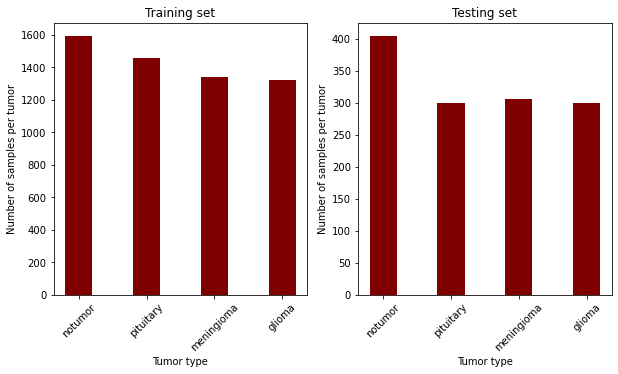

In [3]:
tumors = list(training_images_paths.keys())
tumorTrainingLength =  []
tumorTestingLength =  []

for tumorType in tumors:
    tumorTrainingLength.append(len(training_images_paths[tumorType]))
    tumorTestingLength.append(len(testing_images_paths[tumorType]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(tumors, tumorTrainingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Training set")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(tumors, tumorTestingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Testing set")
plt.xticks(rotation=45)

# plt.show()
plt.savefig("data-distribution.png")

The dataset are well balanced in both training and testing sets.

In [4]:
print(f"Training set size: {sum(tumorTrainingLength)}")
print(f"Testing set size: {sum(tumorTestingLength)}")

Training set size: 5712
Testing set size: 1311


#### Data observation
Let's observe some brain scans of different types of brain tumors.

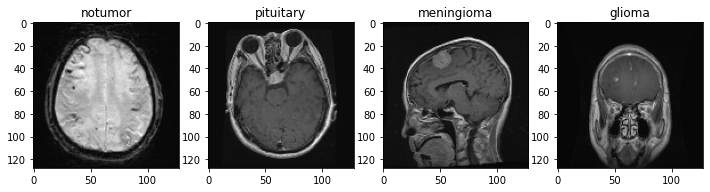

In [5]:
plt.figure(figsize = (12, 5))
for index, tumor in enumerate(tumors):
    imgPath = training_images_paths[tumor][random.randint(1,len(training_images_paths[tumor]))]
    img = cv2.imread(imgPath, 0)
    img = cv2.resize(img, (128,128))
    img = np.array(img)/128
    img = elasticdeform.deform_random_grid(img, sigma=2, mode='constant')
    plt.subplot(1,4,(index+1))
    plt.title(tumor)
    plt.imshow(img, cmap='gray')

### Data transformation

Now that we are more familiar with the data, let's start thinking of transformations we can apply. We will start off by performing basic operations such as data loaders, label encoder and decoder. From there, we will apply transformations on the MRI scans and finally normalize the data.

In [6]:
class powerGammaEnhance(object):
    def __call__(self, img):
        c = random.uniform(0.8, 1.2)
        gamma = random.uniform(0.8, 1.2)
        gammaImg = c * (img ** gamma)
        return gammaImg
    
class scaleImage(object):
    def __call__(self, img):
        rows, cols, ch = img.shape
        a, b = 0.8, 1.2
        alpha = (b-a)*np.random.random_sample(3) + a
        cx = alpha[0]; cy = alpha[0]
        
        M = np.float32([[cx,0,0],[0,cy,0]])
        I_scale = cv2.warpAffine(img.numpy(),M,(cols,rows))
        t = torch.from_numpy(I_scale)
        return t
    
class elasticTransform(object):
    def __call__(self, img):
        sigmaValue = [2,5,8]
        choice = np.random.randint(len(sigmaValue))
        img = elasticdeform.deform_random_grid(img.numpy(), axis=(1,2), sigma=2)
        t = torch.from_numpy(img)
        return t

In [7]:
def transform(transformType):
    if transformType=="nothing":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    if transformType=="brightness":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            powerGammaEnhance(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    if transformType=="flip":
        choice = np.random.randint(2)
        if choice == 0:
            dataTransformer = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        if choice == 1:
            dataTransformer = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.RandomVerticalFlip(p=1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            
    if transformType=="rotation":
        degrees = [0,15,30,60,90]
        choice = np.random.randint(len(degrees))
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.RandomRotation(degrees[choice]),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    if transformType=="scale":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            scaleImage(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    if transformType=="elastic":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            elasticTransform(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    return dataTransformer

#### Preview transformation on brain image

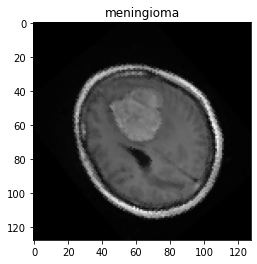

In [14]:
training_set = ImageFolder("./data/Training", transform=transform("rotation"))
train_loader = DataLoader(training_set, 64, shuffle=True, drop_last=True)

for img, label in train_loader:
    plt.title(training_set.classes[label[0]])
    plt.imshow(img[0].squeeze()[0,:,:], cmap='gray')
    break

## Model

Our data generator is now ready to feed batches of data into a model. Let's design a model and pass it our training data.

In [15]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1) 
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.pool1=nn.MaxPool2d(kernel_size=2) 
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1) 
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.pool2=nn.MaxPool2d(kernel_size=2) 
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1) 
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.pool3=nn.MaxPool2d(kernel_size=2) 

        self.drop = nn.Dropout(0.15)
        self.relu = nn.ReLU()
        
        self.fc=nn.Linear(32*16*16, 4)
        
    def forward(self,img):
        output = self.conv1(img)
        output = self.relu(self.bn1(output))
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu(self.bn2(output))
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu(self.bn3(output))
        output = self.pool3(output)
        
        output = self.drop(output)
        output=output.view(-1, 32*16*16)
        output=self.fc(output)
        return output

In [16]:
def train(model, train_loader, validation_loader, optimizier, loss_fun, transformType, patience=2, epochs=40):
    training_accuracies = []
    training_losses = []
    validation_accuracies = []
    validation_losses = []
    
    # Early stopping
    the_last_loss = 100
    trigger_times = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_accuracy=0.0
        train_loss=0.0
        
        for images, labels in train_loader:
            # Zero grads
            optimizer.zero_grad()
        
            # Predict
            outputs=model(images)
            
            # Compute loss and update gradients
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()
            
            predicted = outputs.argmax(axis=1)
            train_accuracy+=int(torch.sum(predicted==labels.data))
            train_loss+= loss.cpu().data*images.size(0)
            
        train_accuracy=train_accuracy/len(training_set)
        train_loss=train_loss/len(training_set)
        training_accuracies.append(train_accuracy * 100)
        training_losses.append(train_loss.item())
        
        # Validation
        model.eval()
        validation_accuracy=0.0
        validation_loss = 0.0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                # Predict
                outputs=model(images)
                
                loss=loss_function(outputs,labels)
                validation_loss+= loss.cpu().data*images.size(0)

                predicted = outputs.argmax(axis=1)
                validation_accuracy+=int(torch.sum(predicted==labels.data))
            
        validation_accuracy=validation_accuracy/len(validation_set)
        validation_loss=validation_loss/len(validation_set)
        validation_accuracies.append(validation_accuracy*100)
        validation_losses.append(validation_loss.item())

        if validation_loss.item() > the_last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'EARLY STOPPING - Trigger times: {trigger_times}')
                torch.save(model.state_dict(), f'{transformType}-model.pt')
                return training_accuracies, validation_accuracies, training_losses, validation_losses
        else:
            trigger_times = 0

        the_last_loss = validation_loss.item()
        
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        print(f'Training loss: {str(train_loss.item())} Training acc: {str(train_accuracy*100)}')
        print(f'Validation loss: {str(validation_loss.item())} Validation acc: {str(validation_accuracy*100)}')
        print('-'*50)
    
    torch.save(model.state_dict(), f'{transformType}-model.pt')
    return training_accuracies, validation_accuracies, training_losses, validation_losses
    
def test(model, test_loader, transformType, metrics):
    y_pred=[]
    y_actual=[]
    model.load_state_dict(torch.load(f'{transformType}-model.pt'))
    with torch.no_grad():
        testing_accuracy = 0
        for images, labels in test_loader:
            # Predict
            outputs=model(images)
            
            # Accuracy
            predicted = outputs.argmax(axis=1)
            testing_accuracy+=int(torch.sum(predicted==labels.data))
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
            y_pred+=list(np.array(predicted.detach().to('cpu')).flatten())
            
        print(f"Testing accuracy: {(testing_accuracy/len(testing_set))*100}\n")
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        
        metrics[transformType]['testingAccuracy'] = (testing_accuracy/len(testing_set))*100
        metrics[transformType]['y_actual'] = y_actual
        metrics[transformType]['y_pred'] = y_pred
        
        return y_actual, y_pred

#### Train model

In [94]:
from torch.optim import Adam
metrics = {}
EPOCHS = 30

for transformType in ["nothing", "brightness", "flip", "rotation", "scale", "elastic"]:
    model = ConvNet()
    optimizer=Adam(model.parameters(),lr=0.001)
    loss_function=nn.CrossEntropyLoss()
    training_set = ImageFolder("./data/Training", transform=transform(transformType))
    testing_set = ImageFolder("./data/Testing", transform=transform(transformType))
    training_set, validation_set = random_split(training_set, [4570, 1142])
    
    train_loader = DataLoader(training_set, 64, shuffle=True, drop_last=True)
    validation_loader = DataLoader(validation_set, 64, shuffle=True, drop_last=True)
    test_loader = DataLoader(testing_set, 64, shuffle=True, drop_last=True)

    print(f"=================== Training model for {transformType} ===================")
    training_accuracies, validation_accuracies, training_losses, validation_losses = train(model, train_loader, validation_loader, optimizer, loss_function, transformType, patience=3, epochs=EPOCHS)
    metrics[transformType] = {
        "trainingAccuracies": training_accuracies,
        "validationAccuracies": validation_accuracies,
        "trainingLosses": training_losses,
        "validationLosses": validation_losses
    }
    
    print("\nTESTING MODEL...")
    y_actual, y_pred = test(model, test_loader, transformType, metrics)

=================== Training model for brightness ===================
[INFO]: Epoch 1 of 30
Training loss: 0.8877727389335632 Training acc: 69.47483588621444
Validation loss: 0.47633594274520874 Validation acc: 76.18213660245185
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training loss: 0.4468303918838501 Training acc: 82.27571115973743
Validation loss: 0.38771378993988037 Validation acc: 80.73555166374781
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training loss: 0.364700585603714 Training acc: 86.10503282275711
Validation loss: 0.36979061365127563 Validation acc: 83.18739054290718
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training loss: 0.33621013164520264 Training acc: 87.3741794310722
Validation loss: 0.3585236966609955 Validation acc: 83.36252189141857
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training loss: 0.23685738444328308 Training acc: 90.61269146608315
Val

[INFO]: Epoch 26 of 30
Training loss: 0.018916983157396317 Training acc: 98.81838074398249
Validation loss: 0.2659159004688263 Validation acc: 88.87915936952714
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training loss: 0.025152014568448067 Training acc: 98.59956236323852
Validation loss: 0.25760263204574585 Validation acc: 89.49211908931699
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training loss: 0.030274085700511932 Training acc: 98.49015317286653
Validation loss: 0.23395606875419617 Validation acc: 89.05429071803853
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training loss: 0.03367271646857262 Training acc: 98.49015317286653
Validation loss: 0.3287460207939148 Validation acc: 88.09106830122592
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training loss: 0.014076011255383492 Training acc: 99.10284463894968
Validation loss: 0.23223280906677246 Validation acc: 89.5796

[INFO]: Epoch 9 of 30
Training loss: 0.25490763783454895 Training acc: 89.82494529540482
Validation loss: 0.26737573742866516 Validation acc: 86.95271453590193
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training loss: 0.2272718995809555 Training acc: 91.2035010940919
Validation loss: 0.3852023184299469 Validation acc: 81.78633975481611
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training loss: 0.2490304559469223 Training acc: 90.43763676148797
Validation loss: 0.27594447135925293 Validation acc: 86.1646234676007
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training loss: 0.1818932592868805 Training acc: 92.64770240700219
Validation loss: 0.3066645562648773 Validation acc: 86.33975481611208
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training loss: 0.18645715713500977 Training acc: 92.6258205689278
Validation loss: 0.3152386546134949 Validation acc: 84.93870402802102
-

## Evaluate results

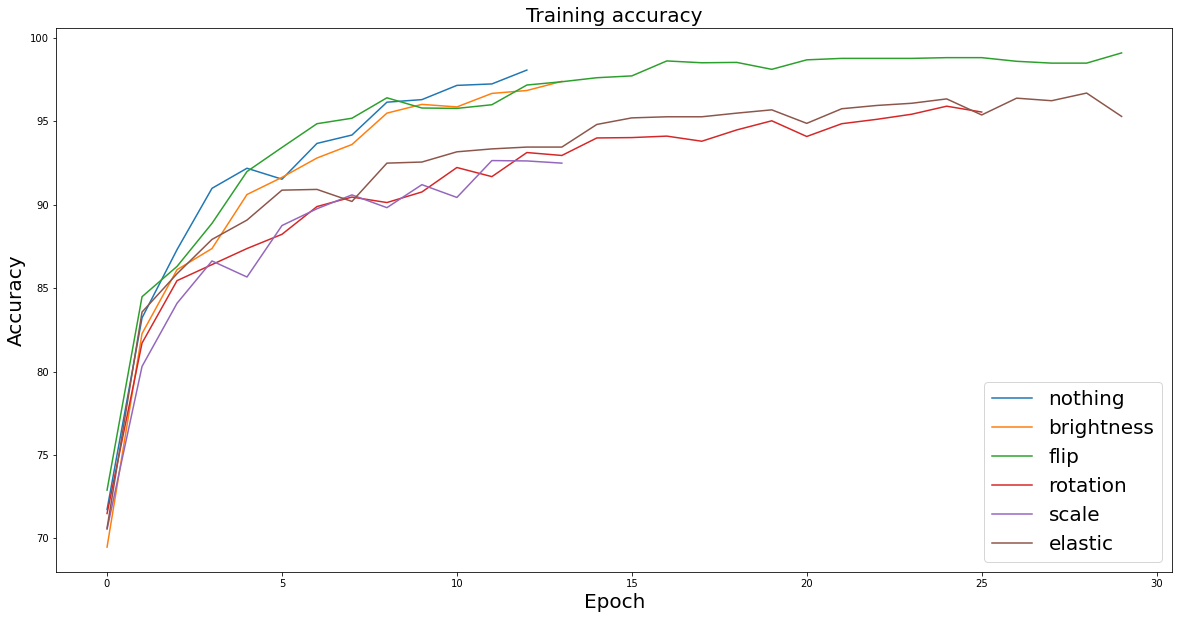

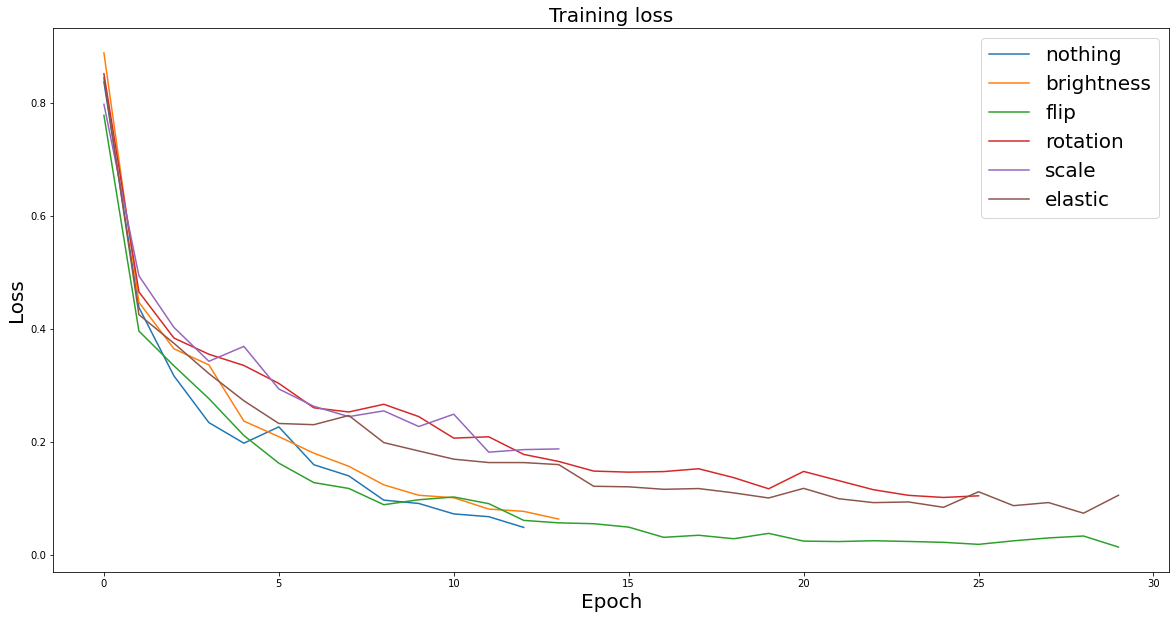

In [151]:
fig = plt.figure(figsize = (20, 10))

for transformType in ["nothing", "brightness", "flip", "rotation", "scale", "elastic"]:    
    plt.title("Training accuracy", fontdict={'fontsize': 20})
    plt.xlabel("Epoch", fontdict={'fontsize': 20})
    plt.ylabel("Accuracy", fontdict={'fontsize': 20})
    x = np.arange(len(metrics[transformType]['trainingAccuracies']))
    plt.plot(x, metrics[transformType]['trainingAccuracies'], label=f"{transformType}")
    plt.legend(prop={'size': 20})
    plt.savefig("performance.png")
    
fig = plt.figure(figsize = (20, 10))
for transformType in ["nothing", "brightness", "flip", "rotation", "scale", "elastic"]:    
    plt.title("Training loss", fontdict={'fontsize': 20})
    plt.xlabel("Epoch", fontdict={'fontsize': 20})
    plt.ylabel("Loss", fontdict={'fontsize': 20})
    x = np.arange(len(metrics[transformType]['trainingLosses']))
    plt.plot(x, metrics[transformType]['trainingLosses'], label=f"{transformType}")
    plt.legend(prop={'size': 20})
    plt.savefig("loss.png")

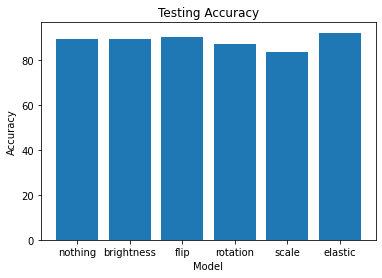

In [153]:
def plt_bar_chart(X, y, xlabel, ylabel, title):
    '''
    Plot bar chart for model and metric
    '''
    plt.bar(X, y)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()
    
testing_acc = []
for transformType in ["nothing", "brightness", "flip", "rotation", "scale", "elastic"]:
    testing_acc.append(metrics[transformType]["testingAccuracy"])
    
plt_bar_chart(["nothing", "brightness", "flip", "rotation", "scale", "elastic"], testing_acc, "Model", "Accuracy", "Testing Accuracy")

**Note: confusion matrix plotting function has been taken from the following source.**

Source of code: https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [157]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

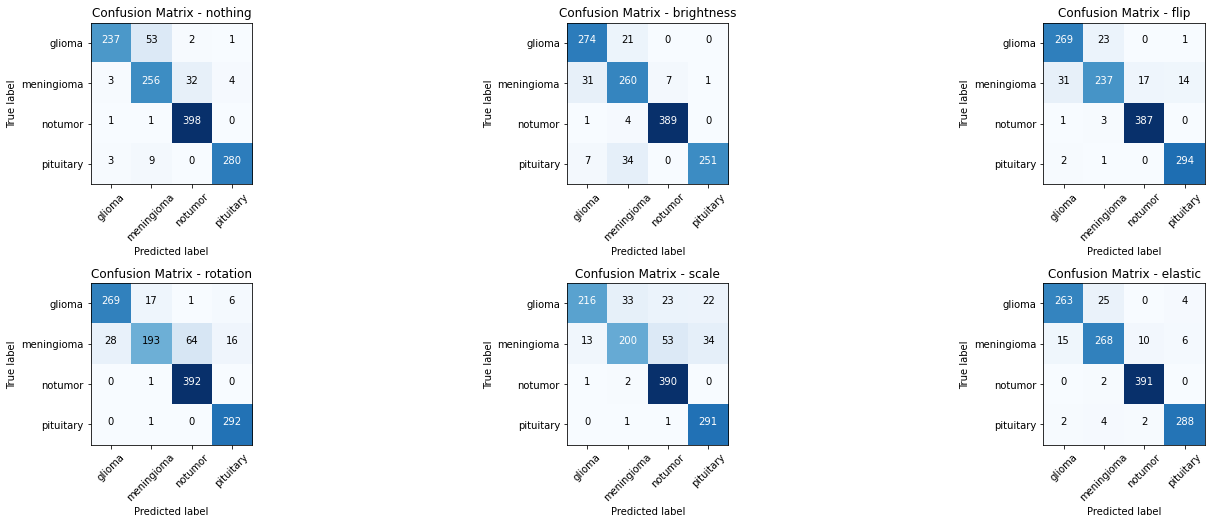

In [158]:
fig = plt.figure(figsize = (20,10))
for index, transformType in enumerate(["nothing", "brightness", "flip", "rotation", "scale", "elastic"]):
    plt.subplot(3,3,index+1)
    plot_confusion_matrix(confusion_matrix(metrics[transformType]['y_actual'], metrics[transformType]['y_pred']), testing_set.classes, title=f"Confusion Matrix - {transformType}")

In [156]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

for transformType in ["nothing", "brightness", "flip", "rotation", "scale","elastic"]:
    print(f"========{transformType}========")
    print(f"Accuracy: {round(accuracy_score(metrics[transformType]['y_actual'], metrics[transformType]['y_pred'])*100, 3)}%")
    print(f"Precision: {round(precision_score(metrics[transformType]['y_actual'], metrics[transformType]['y_pred'], average='weighted')*100, 3)}%")
    print(f"Recall: {round(recall_score(metrics[transformType]['y_actual'], metrics[transformType]['y_pred'], average='weighted')*100, 3)}%")
    print(f"F1: {round(f1_score(metrics[transformType]['y_actual'], metrics[transformType]['y_pred'], average='weighted')*100, 3)}%\n")


========nothing========
Accuracy: 91.484%
Precision: 91.932%
Recall: 91.484%
F1: 91.462%

========brightness========
Accuracy: 91.719%
Precision: 92.173%
Recall: 91.719%
F1: 91.793%

========flip========
Accuracy: 92.734%
Precision: 92.631%
Recall: 92.734%
F1: 92.584%

========rotation========
Accuracy: 89.531%
Precision: 89.764%
Recall: 89.531%
F1: 88.91%

========scale========
Accuracy: 85.703%
Precision: 86.27%
Recall: 85.703%
F1: 85.09%

========elastic========
Accuracy: 94.531%
Precision: 94.503%
Recall: 94.531%
F1: 94.503%

